### Paths

In [2]:
source_image_folder = '../data/images_cropped_sample'
csv_path = '../data/stars_classification_with_images.csv'

### Imports

In [46]:
from os import listdir

import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer, make_column_selector, make_column_transformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer

from tensorflow.keras.models import Sequential
from tensorflow.keras import layers

import matplotlib.pyplot as plt
import joblib


### Create DataFrame

In [4]:
# retrieve list of images in scrapped images directory
image_names = [f for f in listdir(source_image_folder)]

# create dataframe out of data stored in images names
image_names_df = pd.DataFrame(
    columns=[
        'obj_id',
        'alpha',
        'delta',
        'label',
        'redshift_value'
    ]
)
for image_name in image_names:
    image_row = image_name.replace('.jpg', '').split('_')
    obj_id = image_row[0]
    alpha = float(image_row[1])
    delta = float(image_row[2])
    label = image_row[3]
    redshift_value = float(image_row[4])
    row = { 'obj_id':obj_id, 'alpha':alpha, 'delta':delta, 'label': label, 'redshift_value': redshift_value }
    new_df = pd.DataFrame([row])
    image_names_df = pd.concat([image_names_df, new_df], axis=0, ignore_index=True)

# create dataframe out of original csv
orignal_csv_df = pd.read_csv(csv_path)

# join dataframes based on alpha (ra) & delta (dec)
merged_df = pd.merge(
    image_names_df,
    orignal_csv_df,
    how='left',
    on=['alpha', 'delta']
)

merged_df.head()

/var/folders/n_/nc46cl6n11n_529xy5xp_7jr0000gn/T/ipykernel_48218/2996225701.py:23: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  image_names_df = pd.concat([image_names_df, new_df], axis=0, ignore_index=True)


,obj_id,alpha,delta,label,redshift_value,obj_ID,u,g,r,i,...,rerun_ID,cam_col,field_ID,spec_obj_ID,class,redshift,plate,MJD,fiber_ID,image_url
0,1237664673256571815,206.152742,35.783247,GALAXY,1.010923,1.237665e+18,26.30457,25.89210,21.78114,20.54924,...,301,4,130,1.154746e+19,GALAXY,1.010923,10256,58193,843,https://dr12.sdss.org//sas/dr12/boss/photoObj/...
1,1237678597545591138,341.669732,2.683017,STAR,1.209123,1.237679e+18,21.36229,21.91844,21.26442,21.13737,...,301,4,207,1.273170e+19,QSO,1.209123,11308,58426,100,https://dr12.sdss.org//sas/dr12/boss/photoObj/...
2,1237661971714802594,167.435588,7.254149,GALAXY,0.666519,1.237662e+18,23.72051,23.21101,21.19941,19.86738,...,301,4,18,6.038282e+18,GALAXY,0.666519,5363,55956,295,https://dr12.sdss.org//sas/dr12/boss/photoObj/...
3,1237678661426872832,6.576645,4.687866,STAR,2.225737,1.237679e+18,22.62305,21.89907,21.93067,21.70387,...,301,3,110,4.973126e+18,QSO,2.225737,4417,55829,93,https://dr12.sdss.org//sas/dr12/boss/photoObj/...
4,1237680272035807907,331.937003,19.126116,STAR,0.000142,1.237680e+18,20.99358,20.40626,20.57264,20.55044,...,301,3,52,5.653178e+18,STAR,0.000142,5021,55863,124,https://dr12.sdss.org//sas/dr12/boss/photoObj/...


### Clean DataFrame

In [5]:

merged_df_clean = merged_df.drop(
    columns=[
        'obj_id',
        #'label',
        'obj_ID',
        'rerun_ID',
        'run_ID',
        'cam_col',
        'class',
        'redshift',
        'plate',
        'MJD',
        'fiber_ID',
        'image_url',
        'field_ID',
        'spec_obj_ID'
    ],
    axis=1
)
#     columns=[
#         'obj_Id',
#         # 'rerun_ID',
#         # 'cam_col',

#     ]
# )

merged_df_clean = merged_df_clean.rename(columns={'redshift_value': 'redshift'})

merged_df_clean.head(5)

merged_df_clean.dtypes


alpha       float64
delta       float64
label        object
redshift    float64
u           float64
g           float64
r           float64
i           float64
z           float64
dtype: object

### Preprocess

In [6]:
X = merged_df_clean.drop("redshift", axis=1)
y = merged_df_clean['redshift']
X

,alpha,delta,label,u,g,r,i,z
0,206.152742,35.783247,GALAXY,26.30457,25.89210,21.78114,20.54924,19.29786
1,341.669732,2.683017,STAR,21.36229,21.91844,21.26442,21.13737,21.11002
2,167.435588,7.254149,GALAXY,23.72051,23.21101,21.19941,19.86738,19.27868
3,6.576645,4.687866,STAR,22.62305,21.89907,21.93067,21.70387,21.40456
4,331.937003,19.126116,STAR,20.99358,20.40626,20.57264,20.55044,20.04577
...,...,...,...,...,...,...,...,...
5430,55.829432,9.764397,STAR,17.79224,16.47265,15.84970,15.59104,15.46414
5431,13.841103,-4.093512,GALAXY,21.97417,22.42726,21.87176,22.33464,21.17168
5432,357.320307,26.080041,STAR,23.24426,22.26608,20.75471,18.77681,17.68333
5433,16.548202,-0.616989,GALAXY,17.47933,15.95861,15.23440,14.83781,14.56005


In [18]:
X.dtypes

alpha    float64
delta    float64
label     object
u        float64
g        float64
r        float64
i        float64
z        float64
dtype: object

In [19]:
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.3,
    random_state=42
)

num_transformer = make_pipeline(StandardScaler())
num_sel = make_column_selector(dtype_include=['float64'])

cat_transformer = OneHotEncoder()
cat_sel = make_column_selector(dtype_include=['object'])

preproc_basic = make_column_transformer(
    (num_transformer, num_sel),
    (cat_transformer, cat_sel),
    remainder='passthrough'
)
preproc_basic

ColumnTransformer(remainder='passthrough',
                  transformers=[('pipeline',
                                 Pipeline(steps=[('standardscaler',
                                                  StandardScaler())]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x1111fe4a0>),
                                ('onehotencoder', OneHotEncoder(),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x1110e4c40>)])

In [20]:
preproc_basic.fit(X_train)

X_train_scaled = preproc_basic.transform(X_train)
X_test_scaled = preproc_basic.transform(X_test)

In [22]:
joblib.dump(preproc_basic, 'preproc_basic.pkl')

['preproc_basic.pkl']

In [21]:
X_train_scaled[0]

array([-0.50742813,  1.81559918, -1.26610157, -1.3841251 , -1.35061063,
       -1.3316821 , -1.26422029,  1.        ,  0.        ])

### Create model

In [39]:
model = Sequential()
model.add(layers.Dense(64, activation='relu', input_dim=9))
model.add(layers.Dense(10, activation='relu'))
model.add(layers.Dense(1, activation='linear'))
model.summary()

/Users/svinchon/.pyenv/versions/3.10.6/envs/to_infinity_and_beyond/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_9 (Dense)                 │ (None, 64)             │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 10)             │           650 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 1)              │            11 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,301 (5.08 KB)

 Trainable params: 1,301 (5.08 KB)

 Non-trainable params: 0 (0.00 B)

### Compile model

In [40]:
model.compile(
    loss='mse',
    optimizer='adam',
    metrics=[
        'mae',
        'mse',
        'accuracy'
    ]
)

In [41]:
y_train.mean()

0.5960877172211989

### Train model

In [42]:
history = model.fit(
    X_train_scaled,
    y_train,
    epochs=100,
    batch_size=32,
    verbose=1,
    validation_split=0.3,
    #callbacks=[es],
)

Epoch 1/100
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0010 - loss: 0.7639 - mae: 0.5447 - mse: 0.7639 - val_accuracy: 0.0018 - val_loss: 0.3429 - val_mae: 0.3514 - val_mse: 0.3429
Epoch 2/100
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 561us/step - accuracy: 0.0012 - loss: 0.4232 - mae: 0.3876 - mse: 0.4232 - val_accuracy: 0.0026 - val_loss: 0.3299 - val_mae: 0.3182 - val_mse: 0.3299
Epoch 3/100
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 505us/step - accuracy: 0.0031 - loss: 0.3895 - mae: 0.3456 - mse: 0.3895 - val_accuracy: 0.0026 - val_loss: 0.3295 - val_mae: 0.3156 - val_mse: 0.3295
Epoch 4/100
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 501us/step - accuracy: 0.0011 - loss: 0.3662 - mae: 0.3396 - mse: 0.3662 - val_accuracy: 0.0026 - val_loss: 0.3236 - val_mae: 0.3071 - val_mse: 0.3236
Epoch 5/100
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 516us/step - accuracy: 0.0012 - loss: 0.3572 - mae: 0.3337 - mse: 0.3572 - val_accuracy: 0.0026 - val_loss: 0.3271 - val_mae: 0.3086 - val_mse: 0.3271
Epoch 6/100
84/84 ━━━━━━━━━━━━━━━━━━━

### Plot Losses

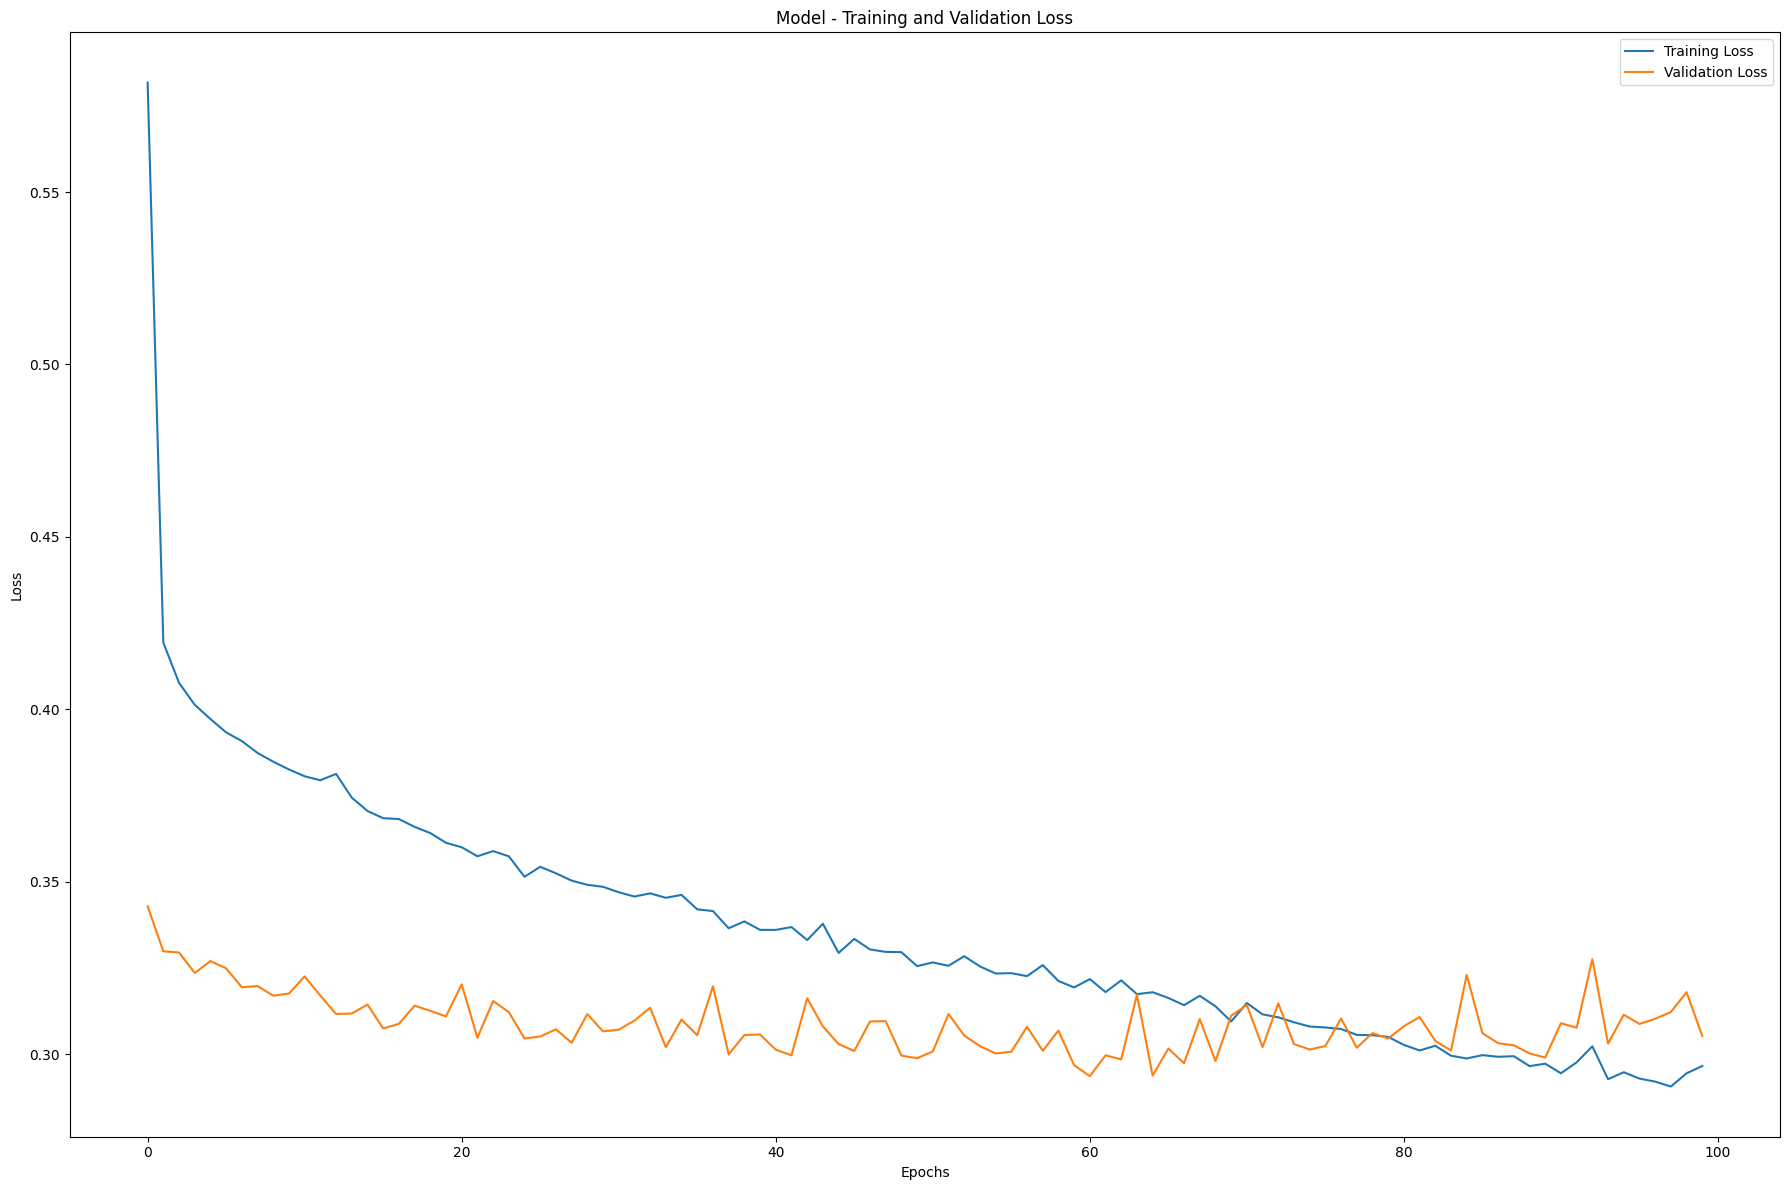

In [43]:
# Plot the training and validation loss and accuracy for all models
import matplotlib.pyplot as plt
plt.figure(figsize=(18, 12))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title(f'Model - Training and Validation Loss')
plt.legend()
plt.tight_layout()
plt.show()

### Plot MAEs

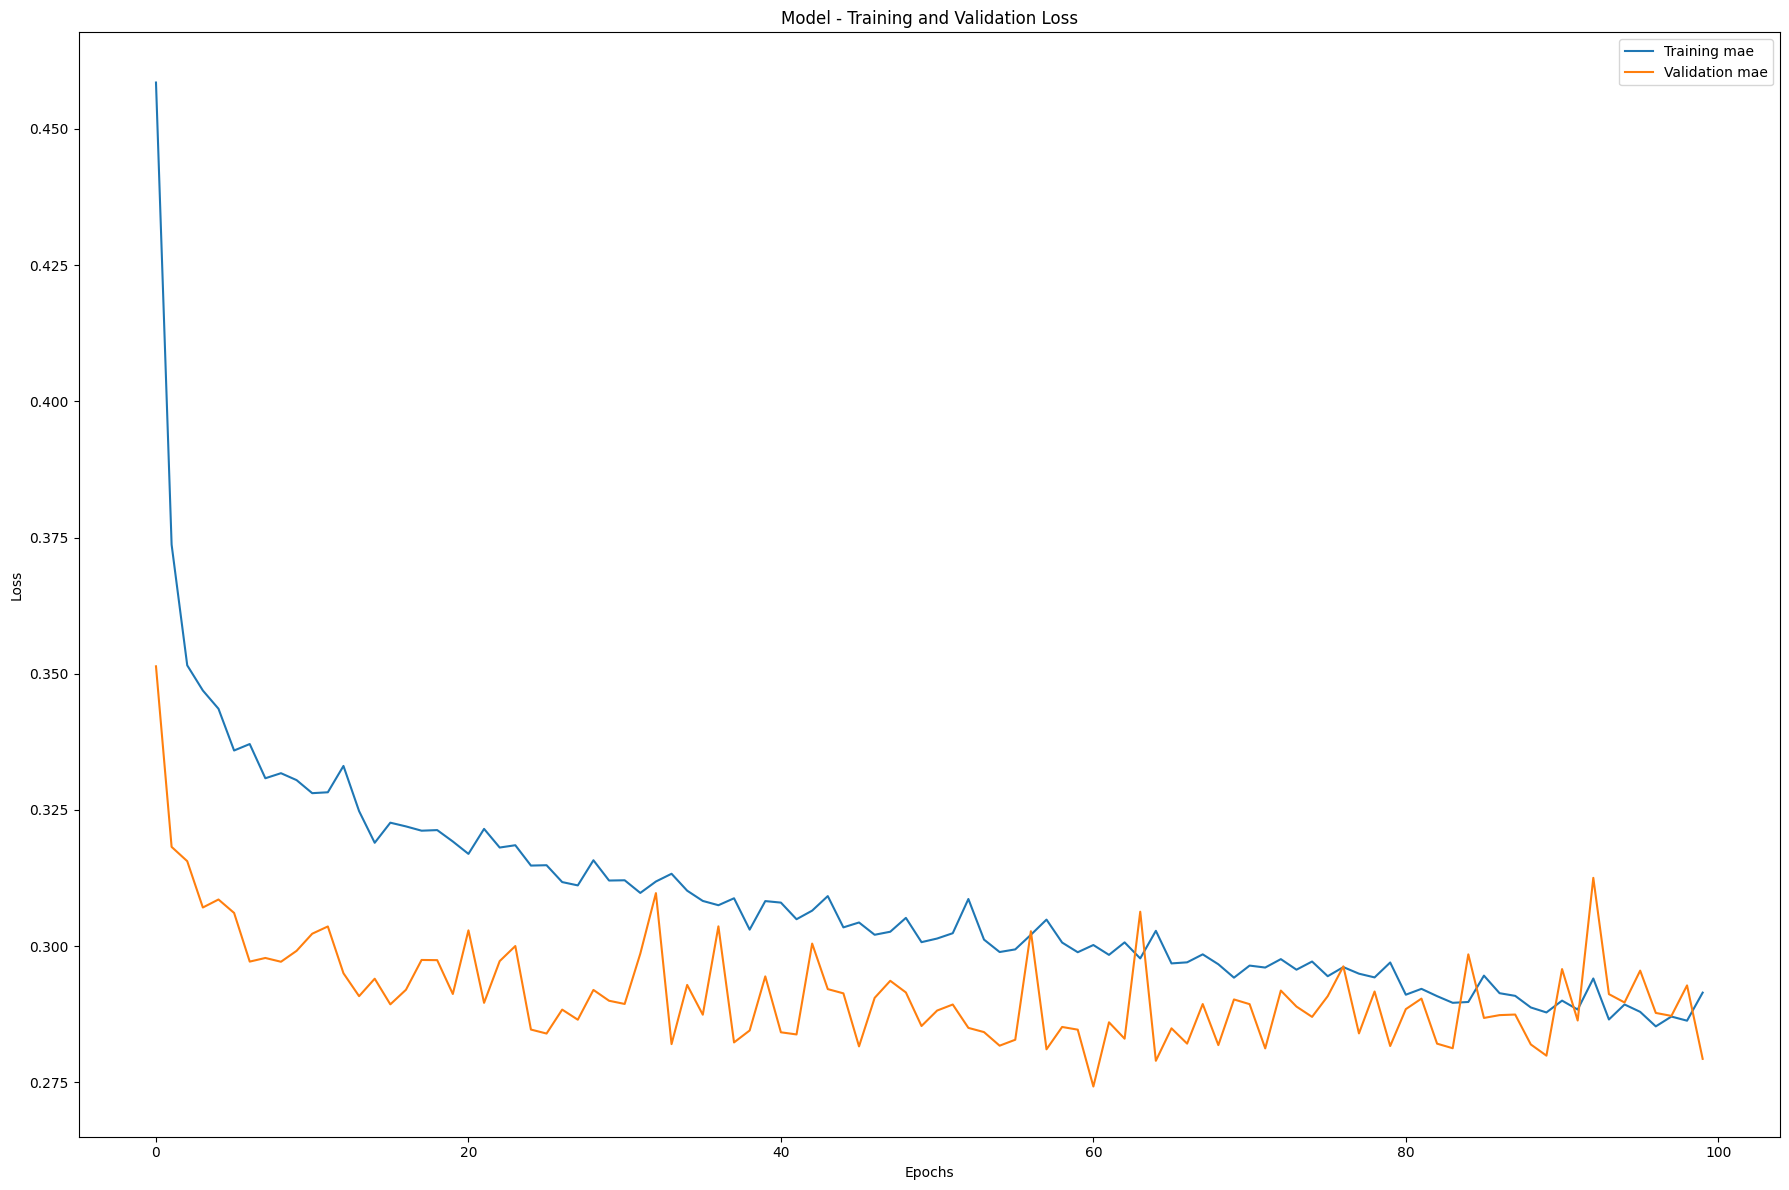

In [44]:
# Plot the training and validation loss and accuracy for all models
import matplotlib.pyplot as plt
plt.figure(figsize=(18, 12))
plt.plot(history.history['mae'], label='Training mae')
plt.plot(history.history['val_mae'], label='Validation mae')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title(f'Model - Training and Validation Loss')
plt.legend()
plt.tight_layout()
plt.show()

In [49]:

model.save('../models/chewbacca.h5')
model.save('../models/chewbacca.keras')
joblib.dump(model, '../models/chewbacca.pkl')

['../models/chewbacca.pkl']